<a href="https://colab.research.google.com/github/udaybhaskar717/Solar-Irradiance-Forecasting/blob/main/Random_Forest_Inverter_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [51]:
pip install pvlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import polyfit  # different than np.polyfit

In [53]:
from pvlib import pvsystem
invdb = pvsystem.retrieve_sam("SandiaInverter")

In [54]:
inverter=dict(invdb.ABB__PVI_5000_OUTD_S_US_Z__240V_)

In [55]:
inverter

{'Vac': '240',
 'Pso': 32.035774,
 'Paco': 5000.0,
 'Pdco': 5190.294434,
 'Vdco': 345.0,
 'C0': -3.548084e-06,
 'C1': -1e-05,
 'C2': 0.000445,
 'C3': -0.000412,
 'Pnt': 1.5,
 'Vdcmax': 480.0,
 'Idcmax': 15.044332,
 'Mppt_low': 100.0,
 'Mppt_high': 480.0,
 'CEC_Date': nan,
 'CEC_Type': 'Utility Interactive'}

# Libraries

In [56]:
import numpy as np
import pandas as pd
from numpy.polynomial.polynomial import polyfit  # different than np.polyfit


In [57]:
def _sandia_eff(v_dc, p_dc, inverter):
    '''
    Calculate the inverter AC power without clipping
    '''
    Paco = inverter['Paco']
    Pdco = inverter['Pdco']
    Vdco = inverter['Vdco']
    C0 = inverter['C0']
    C1 = inverter['C1']
    C2 = inverter['C2']
    C3 = inverter['C3']
    Pso = inverter['Pso']

    A = Pdco * (1 + C1 * (v_dc - Vdco))
    B = Pso * (1 + C2 * (v_dc - Vdco))
    C = C0 * (1 + C3 * (v_dc - Vdco))

    return (Paco / (A - B) - C * (A - B)) * (p_dc - B) + C * (p_dc - B)**2

In [58]:
# inverter={

# 'Paco': 1000.0,

# 'Pdco': 1050.0000008984525,

# 'Vdco': 240.0,

# 'Pso' : 9.999999860749542,

# 'C0'  : 9.999994978389884e-07,

# 'C1'  : 9.999996161482867e-05,

# 'C2'  : 0.009999996315292192,

# 'C3'  : 0.0010002283566649965,

# 'Pnt' : 1.0

# }

In [59]:
_sandia_eff(240,5000.0,inverter)

4814.117176062567

In [60]:
dc_voltage_levels = {'Vmin': 220., 'Vnom': 240., 'Vmax': 260.}
p_ac_0 = 1000.

# Sandia

In [61]:
def _sandia_limits(power_ac, p_dc, Paco, Pnt, Pso):
    r'''
    Applies minimum and maximum power limits to `power_ac`
    '''
    power_ac = np.minimum(Paco, power_ac)
    min_ac_power = -1.0 * abs(Pnt)
    below_limit = p_dc < Pso
    try:
        power_ac[below_limit] = min_ac_power
    except TypeError:  # power_ac is a float
        if below_limit:
            power_ac = min_ac_power
    return power_ac

In [62]:
def sandia(v_dc, p_dc, inverter):
    Paco = inverter['Paco']
    Pnt = inverter['Pnt']
    Pso = inverter['Pso']

    power_ac = _sandia_eff(v_dc, p_dc, inverter)
    power_ac = _sandia_limits(power_ac, p_dc, Paco, Pnt, Pso)

    if isinstance(p_dc, pd.Series):
        power_ac = pd.Series(power_ac, index=p_dc.index)

    return power_ac

In [63]:
def sandia_multi(v_dc, p_dc, inverter):
    if len(p_dc) != len(v_dc):
        raise ValueError('p_dc and v_dc have different lengths')
    power_dc = sum(p_dc)
    power_ac = 0. * power_dc

    for vdc, pdc in zip(v_dc, p_dc):
        power_ac += pdc / power_dc * _sandia_eff(vdc, power_dc, inverter)

    return _sandia_limits(power_ac, power_dc, inverter['Paco'],
                          inverter['Pnt'], inverter['Pso'])



In [64]:
def adr(v_dc, p_dc, inverter, vtol=0.10):

    p_nom = inverter['Pnom']
    v_nom = inverter['Vnom']
    pac_max = inverter['Pacmax']
    p_nt = inverter['Pnt']
    ce_list = inverter['ADRCoefficients']
    v_max = inverter['Vmax']
    v_min = inverter['Vmin']
    vdc_max = inverter['Vdcmax']
    mppt_hi = inverter['MPPTHi']
    mppt_low = inverter['MPPTLow']

    v_lim_upper = float(np.nanmax([v_max, vdc_max, mppt_hi]) * (1 + vtol))
    v_lim_lower = float(np.nanmax([v_min, mppt_low]) * (1 - vtol))

    pdc = p_dc / p_nom
    vdc = v_dc / v_nom
    # zero voltage will lead to division by zero, but since power is
    # set to night time value later, these errors can be safely ignored
    with np.errstate(invalid='ignore', divide='ignore'):
        poly = np.array([pdc**0,  # replace with np.ones_like?
                         pdc,
                         pdc**2,
                         vdc - 1,
                         pdc * (vdc - 1),
                         pdc**2 * (vdc - 1),
                         1. / vdc - 1,  # divide by 0
                         pdc * (1. / vdc - 1),  # invalid 0./0. --> nan
                         pdc**2 * (1. / vdc - 1)])  # divide by 0
    p_loss = np.dot(np.array(ce_list), poly)
    power_ac = p_nom * (pdc - p_loss)
    p_nt = -1 * np.absolute(p_nt)

    # set output to nan where input is outside of limits
    # errstate silences case where input is nan
    with np.errstate(invalid='ignore'):
        invalid = (v_lim_upper < v_dc) | (v_dc < v_lim_lower)
    power_ac = np.where(invalid, np.nan, power_ac)

    # set night values
    power_ac = np.where(vdc == 0, p_nt, power_ac)
    power_ac = np.maximum(power_ac, p_nt)

    # set max ac output
    power_ac = np.minimum(power_ac, pac_max)

    if isinstance(p_dc, pd.Series):
        power_ac = pd.Series(power_ac, index=pdc.index)

    return power_ac


# PVWATTS

In [65]:
def pvwatts(pdc, pdc0, eta_inv_nom=0.96, eta_inv_ref=0.9637):
    pac0 = eta_inv_nom * pdc0
    zeta = pdc / pdc0

    # arrays to help avoid divide by 0 for scalar and array
    eta = np.zeros_like(pdc, dtype=float)
    pdc_neq_0 = ~np.equal(pdc, 0)

    # eta < 0 if zeta < 0.006. power_ac is forced to be >= 0 below. GH 541
    eta = eta_inv_nom / eta_inv_ref * (
        -0.0162 * zeta - np.divide(0.0059, zeta, out=eta, where=pdc_neq_0)
        + 0.9858)  # noQA: W503

    power_ac = eta * pdc
    power_ac = np.minimum(pac0, power_ac)
    power_ac = np.maximum(0, power_ac)     # GH 541

    return power_ac

In [66]:
def pvwatts_multi(pdc, pdc0, eta_inv_nom=0.96, eta_inv_ref=0.9637):
   return pvwatts(sum(pdc), pdc0, eta_inv_nom, eta_inv_ref)

In [67]:
def fit_sandia(ac_power, dc_power, dc_voltage, dc_voltage_level, p_ac_0, p_nt):

    voltage_levels = ['Vmin', 'Vnom', 'Vmax']

    # average dc input voltage at each voltage level
    v_d = np.array(
        [dc_voltage[dc_voltage_level == 'Vmin'].mean(),
         dc_voltage[dc_voltage_level == 'Vnom'].mean(),
         dc_voltage[dc_voltage_level == 'Vmax'].mean()])
    v_nom = v_d[1]  # model parameter
    # independent variable for regressions, x_d
    x_d = v_d - v_nom

    # empty dataframe to contain intermediate variables
    coeffs = pd.DataFrame(index=voltage_levels,
                          columns=['a', 'b', 'c', 'p_dc', 'p_s0'], data=np.nan)

    def solve_quad(a, b, c):
        return (-b + (b**2 - 4 * a * c)**.5) / (2 * a)

    # [2] STEP 3E, fit a line to (DC voltage, model_coefficient)
    def extract_c(x_d, add):
        beta0, beta1 = polyfit(x_d, add, 1)
        c = beta1 / beta0
        return beta0, beta1, c

    for d in voltage_levels:
        x = dc_power[dc_voltage_level == d]
        y = ac_power[dc_voltage_level == d]
        # [2] STEP 3B
        # fit a quadratic to (DC power, AC power)
        c, b, a = polyfit(x, y, 2)

        # [2] STEP 3D, solve for p_dc and p_s0
        p_dc = solve_quad(a, b, (c - p_ac_0))
        p_s0 = solve_quad(a, b, c)

        # Add values to dataframe at index d
        coeffs['a'][d] = a
        coeffs['p_dc'][d] = p_dc
        coeffs['p_s0'][d] = p_s0

    b_dc0, b_dc1, c1 = extract_c(x_d, coeffs['p_dc'])
    b_s0, b_s1, c2 = extract_c(x_d, coeffs['p_s0'])
    b_c0, b_c1, c3 = extract_c(x_d, coeffs['a'])

    p_dc0 = b_dc0
    p_s0 = b_s0
    c0 = b_c0

    # prepare dict and return
    return {'Paco': p_ac_0, 'Pdco': p_dc0, 'Vdco': v_nom, 'Pso': p_s0,
            'C0': c0, 'C1': c1, 'C2': c2, 'C3': c3, 'Pnt': p_nt}

In [68]:
dc_voltage_levels = {'Vmin': 220., 'Vnom': 240., 'Vmax': 260.}
p_ac_0 = 1000.

In [69]:
dc_voltage_levels

{'Vmin': 220.0, 'Vnom': 240.0, 'Vmax': 260.0}

In [70]:
from pvlib import pvsystem
invdb = pvsystem.retrieve_sam('CECInverter')
# inverter = invdb.AE_Solar_Energy__AE6_0__277V__277V__CEC_2012_
# inverter
# Vac           277.000000
# Paco         6000.000000
# Pdco         6165.670000
# Vdco          361.123000
# Pso            36.792300
# C0             -0.000002
# C1             -0.000047
# C2             -0.001861
# C3              0.000721
# Pnt             0.070000
# Vdcmax        600.000000
# Idcmax         32.000000
# Mppt_low      200.000000
# Mppt_high     500.000000
# Name: AE_Solar_Energy__AE6_0__277V__277V__CEC_2012_, dtype: float64

In [71]:
inverter = invdb.ABB__PVI_5000_OUTD_US__240V_

In [72]:
sandia(5000,600,inverter)

509.9818226006011

In [73]:
df_power=pd.read_csv("/content/drive/MyDrive/IITB_Floating_Solar_Plant/DC_Power_Generated_RandomForest.csv")

In [74]:
df_power

,Date,Max_Vdc,Max_Pdc,Tc
0,2022-01-01 06:00:00+05:30,0.0,0.0,297.35
1,2022-01-01 06:15:00+05:30,0.0,0.0,297.25
2,2022-01-01 06:30:00+05:30,0.0,0.0,297.25
3,2022-01-01 06:45:00+05:30,0.0,0.0,297.25
4,2022-01-01 07:00:00+05:30,0.0,0.0,297.25
...,...,...,...,...
955,2022-01-11 04:45:00+05:30,0.0,0.0,293.05
956,2022-01-11 05:00:00+05:30,0.0,0.0,293.05
957,2022-01-11 05:15:00+05:30,0.0,0.0,292.95
958,2022-01-11 05:30:00+05:30,0.0,0.0,292.95


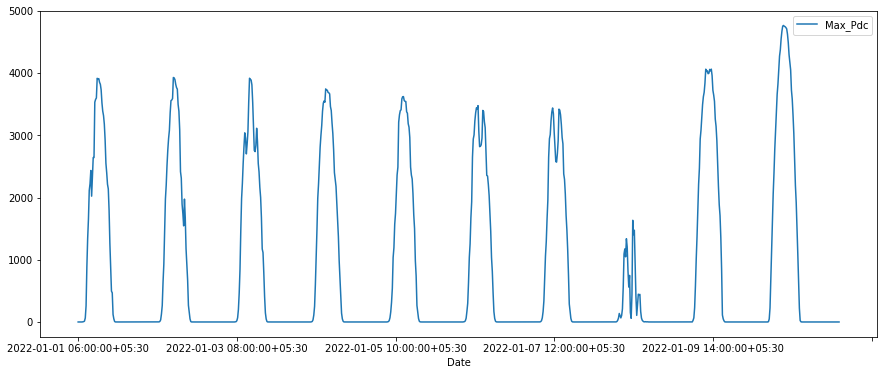

In [75]:
df_power.set_index('Date')[["Max_Pdc"]].iloc[:96*10,:].plot(figsize=(15,6))

In [76]:
df_power

,Date,Max_Vdc,Max_Pdc,Tc
0,2022-01-01 06:00:00+05:30,0.0,0.0,297.35
1,2022-01-01 06:15:00+05:30,0.0,0.0,297.25
2,2022-01-01 06:30:00+05:30,0.0,0.0,297.25
3,2022-01-01 06:45:00+05:30,0.0,0.0,297.25
4,2022-01-01 07:00:00+05:30,0.0,0.0,297.25
...,...,...,...,...
955,2022-01-11 04:45:00+05:30,0.0,0.0,293.05
956,2022-01-11 05:00:00+05:30,0.0,0.0,293.05
957,2022-01-11 05:15:00+05:30,0.0,0.0,292.95
958,2022-01-11 05:30:00+05:30,0.0,0.0,292.95


In [77]:
inverter

Vac                          240
Pso                    32.035774
Paco                      5000.0
Pdco                 5190.294434
Vdco                       345.0
C0                     -0.000004
C1                      -0.00001
C2                      0.000445
C3                     -0.000412
Pnt                          1.5
Vdcmax                     480.0
Idcmax                 15.044332
Mppt_low                   100.0
Mppt_high                  480.0
CEC_Date                     NaN
CEC_Type     Utility Interactive
Name: ABB__PVI_5000_OUTD_US__240V_, dtype: object

In [78]:
df_power['inverter']=0

In [79]:
df_power

,Date,Max_Vdc,Max_Pdc,Tc,inverter
0,2022-01-01 06:00:00+05:30,0.0,0.0,297.35,0
1,2022-01-01 06:15:00+05:30,0.0,0.0,297.25,0
2,2022-01-01 06:30:00+05:30,0.0,0.0,297.25,0
3,2022-01-01 06:45:00+05:30,0.0,0.0,297.25,0
4,2022-01-01 07:00:00+05:30,0.0,0.0,297.25,0
...,...,...,...,...,...
955,2022-01-11 04:45:00+05:30,0.0,0.0,293.05,0
956,2022-01-11 05:00:00+05:30,0.0,0.0,293.05,0
957,2022-01-11 05:15:00+05:30,0.0,0.0,292.95,0
958,2022-01-11 05:30:00+05:30,0.0,0.0,292.95,0


In [80]:
for i in df_power.index:
  df_power.loc[i,'inverter']=[dict(inverter)]

In [81]:
df_power

,Date,Max_Vdc,Max_Pdc,Tc,inverter
0,2022-01-01 06:00:00+05:30,0.0,0.0,297.35,"{'Vac': '240', 'Pso': 32.035774, 'Paco': 5000...."
1,2022-01-01 06:15:00+05:30,0.0,0.0,297.25,"{'Vac': '240', 'Pso': 32.035774, 'Paco': 5000...."
2,2022-01-01 06:30:00+05:30,0.0,0.0,297.25,"{'Vac': '240', 'Pso': 32.035774, 'Paco': 5000...."
3,2022-01-01 06:45:00+05:30,0.0,0.0,297.25,"{'Vac': '240', 'Pso': 32.035774, 'Paco': 5000...."
4,2022-01-01 07:00:00+05:30,0.0,0.0,297.25,"{'Vac': '240', 'Pso': 32.035774, 'Paco': 5000...."
...,...,...,...,...,...
955,2022-01-11 04:45:00+05:30,0.0,0.0,293.05,"{'Vac': '240', 'Pso': 32.035774, 'Paco': 5000...."
956,2022-01-11 05:00:00+05:30,0.0,0.0,293.05,"{'Vac': '240', 'Pso': 32.035774, 'Paco': 5000...."
957,2022-01-11 05:15:00+05:30,0.0,0.0,292.95,"{'Vac': '240', 'Pso': 32.035774, 'Paco': 5000...."
958,2022-01-11 05:30:00+05:30,0.0,0.0,292.95,"{'Vac': '240', 'Pso': 32.035774, 'Paco': 5000...."


In [82]:
power_ac=[]
for i in np.arange(df_power.shape[0]):
  V_dc,P_dc,inverter=df_power.iloc[i,[1,2,4]]
  power_ac.append(sandia(V_dc,P_dc,inverter))

In [83]:
df_power['power_ac']=power_ac
df_power['Max_Pdc']=df_power['Max_Pdc']

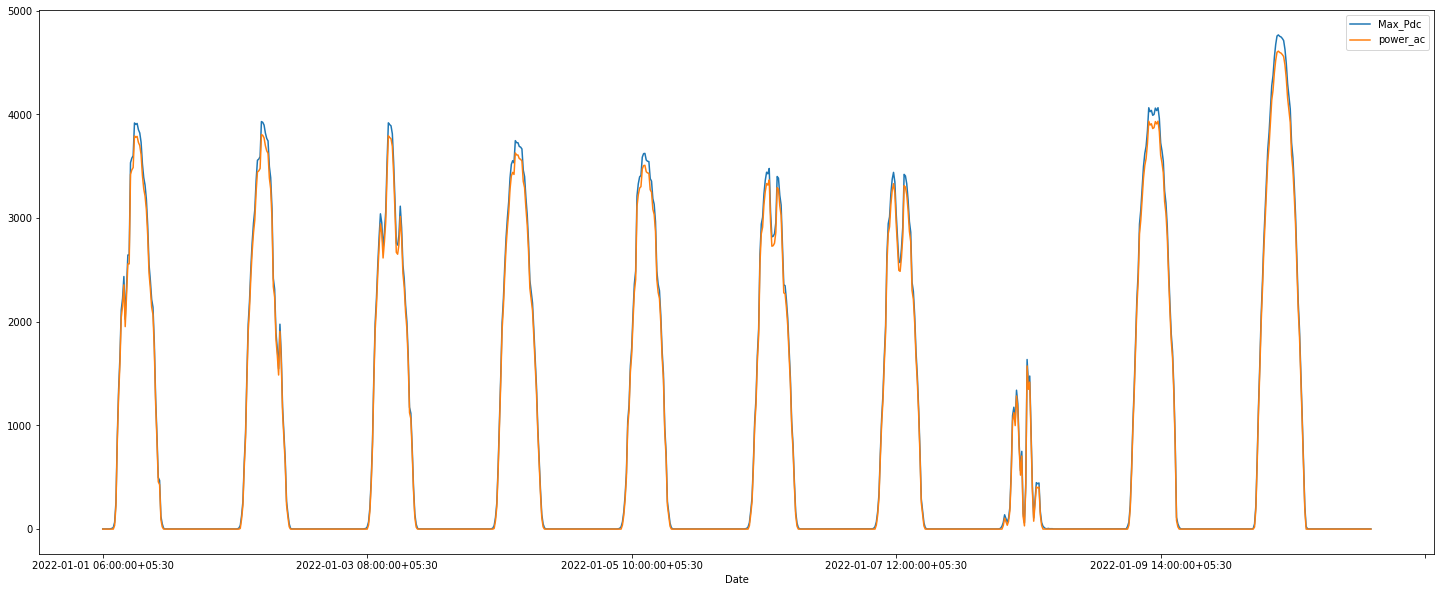

In [84]:
df_power.set_index('Date')[["Max_Pdc","power_ac"]].iloc[:96*10,:].plot(figsize=(25,10))

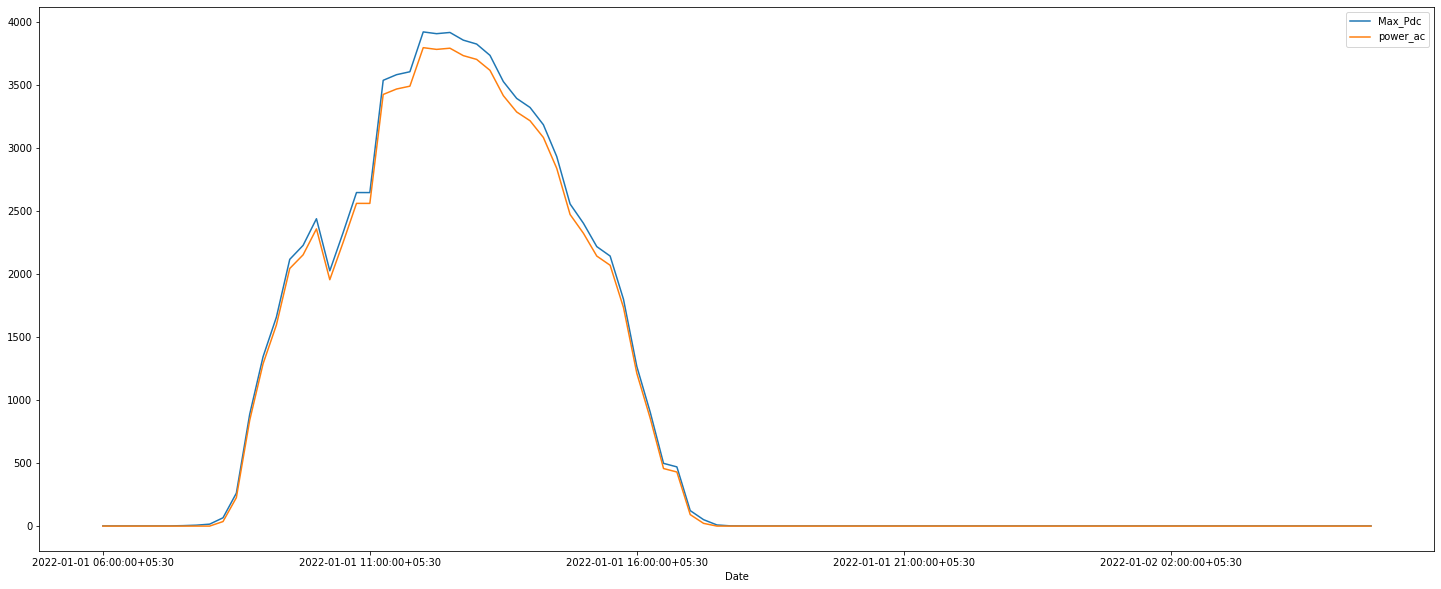

In [85]:
df_power.set_index('Date')[["Max_Pdc","power_ac"]].iloc[:96*1,:].plot(figsize=(25,10))

# PV watts inverter model

In [86]:
def pvwatts(pdc, pdc0=5000, eta_inv_nom=0.93, eta_inv_ref=0.9637):
    pac0 = eta_inv_nom * pdc0
    zeta = pdc / pdc0

    # arrays to help avoid divide by 0 for scalar and array
    eta = np.zeros_like(pdc, dtype=float)
    pdc_neq_0 = ~np.equal(pdc, 0)

    # eta < 0 if zeta < 0.006. power_ac is forced to be >= 0 below. GH 541
    eta = eta_inv_nom / eta_inv_ref * (
        -0.0162 * zeta - np.divide(0.0059, zeta, out=eta, where=pdc_neq_0)
        + 0.9858)  # noQA: W503

    power_ac = eta * pdc
    power_ac = np.minimum(pac0, power_ac)
    power_ac = np.maximum(0, power_ac)     # GH 541

    return power_ac

In [87]:
df_power['Power_ac1']=df_power.Max_Pdc.apply(pvwatts)

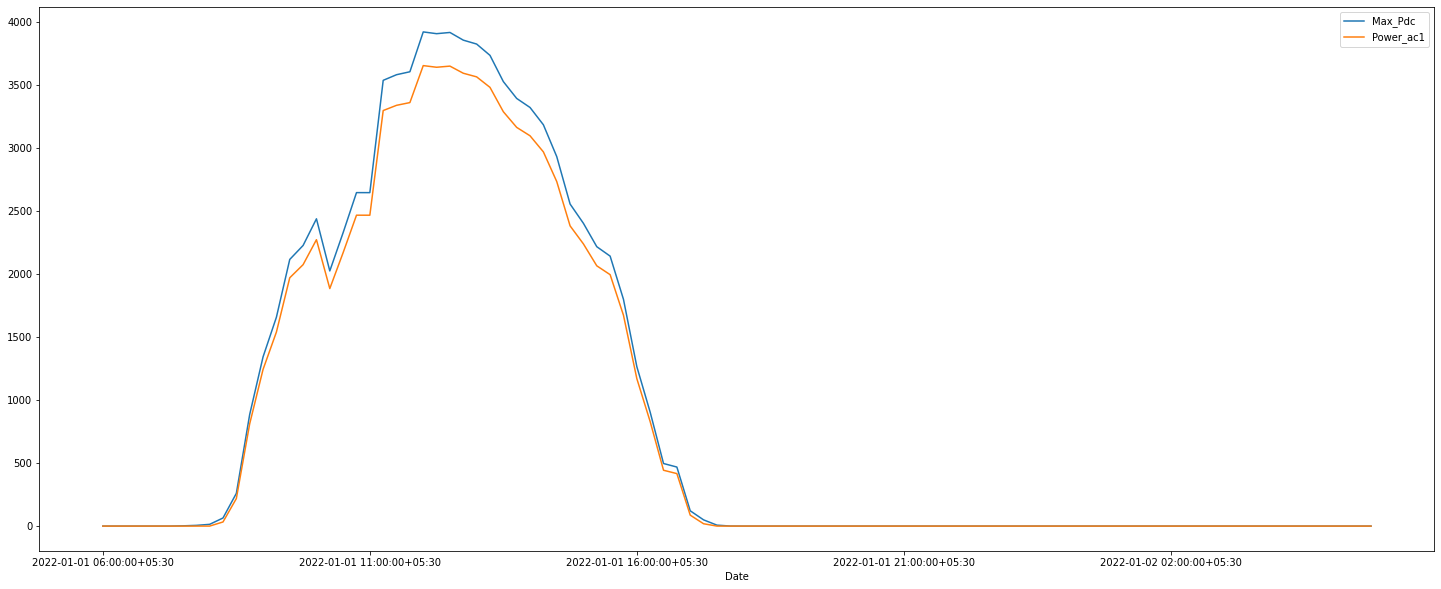

In [88]:
df_power.set_index('Date')[["Max_Pdc",'Power_ac1']].iloc[:96*1,:].plot(figsize=(25,10))

In [89]:
df_power["Max_Pdc"]=df_power["Max_Pdc"]*3
df_power["Power_ac1"]=df_power["Power_ac1"]*3

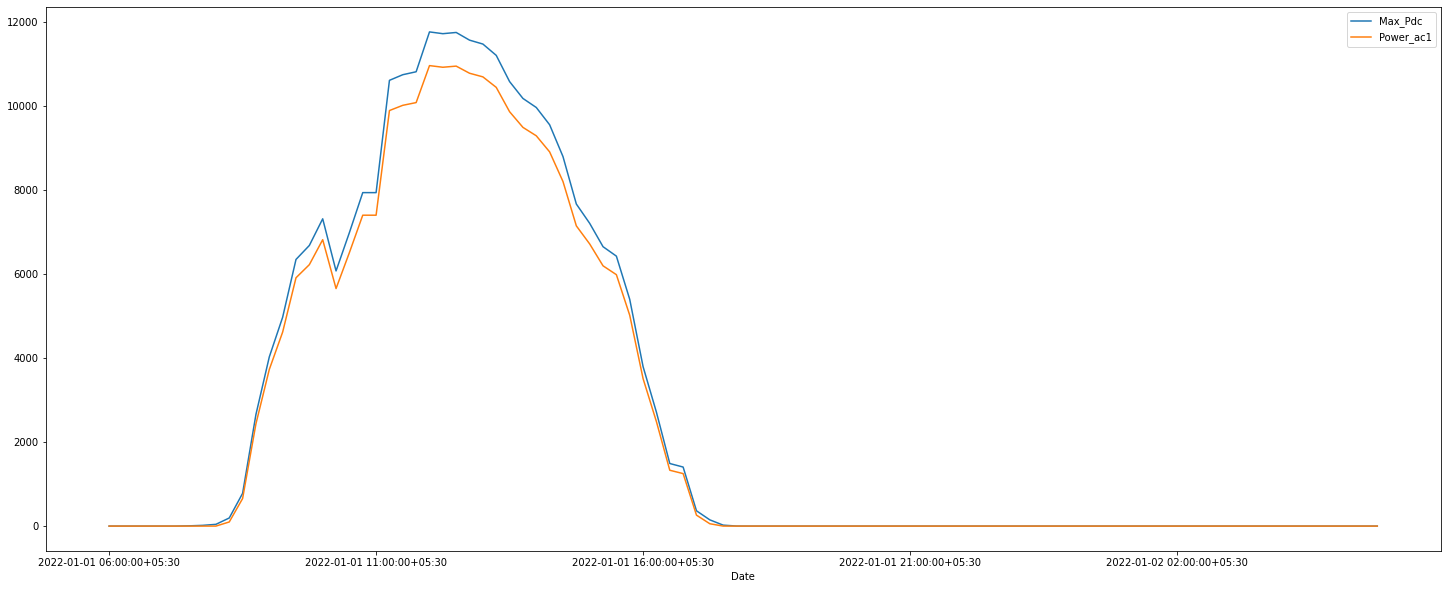

In [90]:
df_power.set_index('Date')[["Max_Pdc",'Power_ac1']].iloc[:96*1,:].plot(figsize=(25,10))
# df_power_LSTM.set_index('Date')[["Max_Pdc",'Power_ac1']].iloc[:96*1,:].plot(figsize=(25,10))

In [91]:
df_power.to_csv("/content/drive/MyDrive/IITB_Floating_Solar_Plant/Forecasted_AC_RandomForest.csv")

In [92]:
df_power_LSTM=pd.read_csv("/content/drive/MyDrive/IITB_Floating_Solar_Plant/Forecasted_AC.csv")

In [93]:
df_power['Power_ac1_LSTM']=df_power_LSTM['Power_ac1']

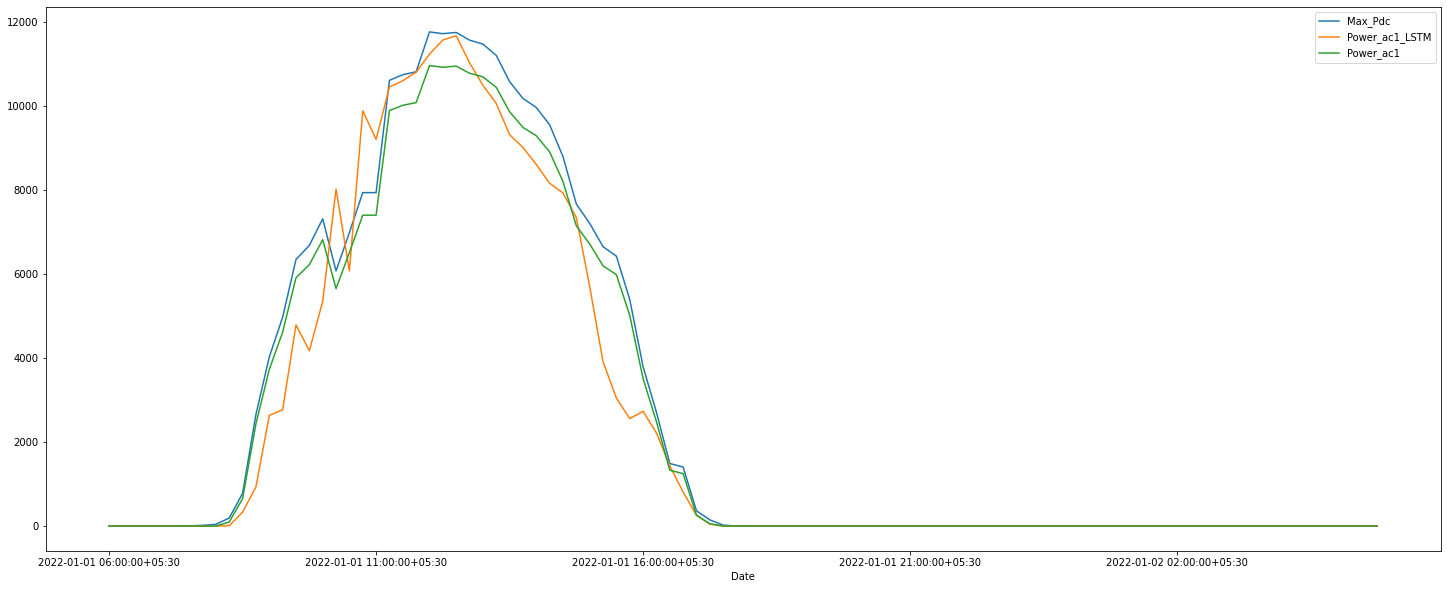

In [95]:
df_power.set_index('Date')[["Max_Pdc",'Power_ac1_LSTM','Power_ac1']].iloc[:96*1,:].plot(figsize=(25,10))
# df_power_LSTM.set_index('Date')[['Power_ac1_LSTM']].iloc[:96*1,:].plot(figsize=(25,10))